In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Combining csv's for model inputs

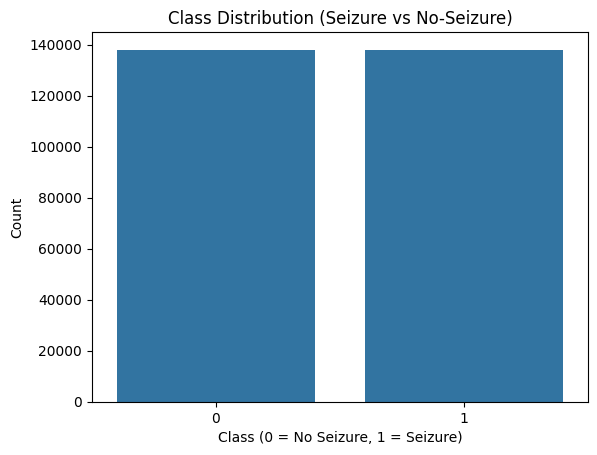

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Directory with CSV files
data_dir = "/content/drive/MyDrive/patientnumber_filenumber_seizureORnoseizure"
dfs_0, dfs_1 = [], []

# Load and label files
for file in os.listdir(data_dir):
    if file.endswith(".csv"):
        label = 0 if "noseizures" in file else 1 if "seizures" in file else None #assign labels according to file name
        if label is not None:
            path = os.path.join(data_dir, file)
            try:
                df = pd.read_csv(path, engine="python", nrows=1000)
                df["outcome"] = label
                if label == 0:
                    dfs_0.append(df)
                else:
                    dfs_1.append(df)
            except Exception as e:
                print(f"Could not load {file}: {e}")

# Combine and balance
df_0 = pd.concat(dfs_0)
df_1 = pd.concat(dfs_1)
min_class = min(len(df_0), len(df_1))
balanced_df = pd.concat([
    df_0.sample(min_class, random_state=42),
    df_1.sample(min_class, random_state=42)
]).sample(frac=1, random_state=42)

# Save to CSV
balanced_df.to_csv("/content/drive/MyDrive/balanced_chbmit_sampled.csv", index=False)

# Visualize Class Distribution
sns.countplot(x='outcome', data=balanced_df)
plt.title('Class Distribution (Seizure vs No-Seizure)')
plt.xlabel('Class (0 = No Seizure, 1 = Seizure)')
plt.ylabel('Count')
plt.show()


Preprocessing: Using mean imputation to handle missing values

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load balanced data
df = pd.read_csv("/content/drive/MyDrive/balanced_chbmit_sampled.csv")

# Check shape & missing values
print("Shape:", df.shape)
print("Missing values:", df.isnull().sum().sum())

# Fill missing values with mean
df = df.fillna(df.mean(numeric_only=True))

# Split features and target
X = df.drop(columns=["outcome"])
y = df["outcome"]

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Normalize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Preprocessing complete.")

Shape: (276000, 97)
Missing values: 19116057
Preprocessing complete.


Data Visualization of classes (ictal vs preictal)

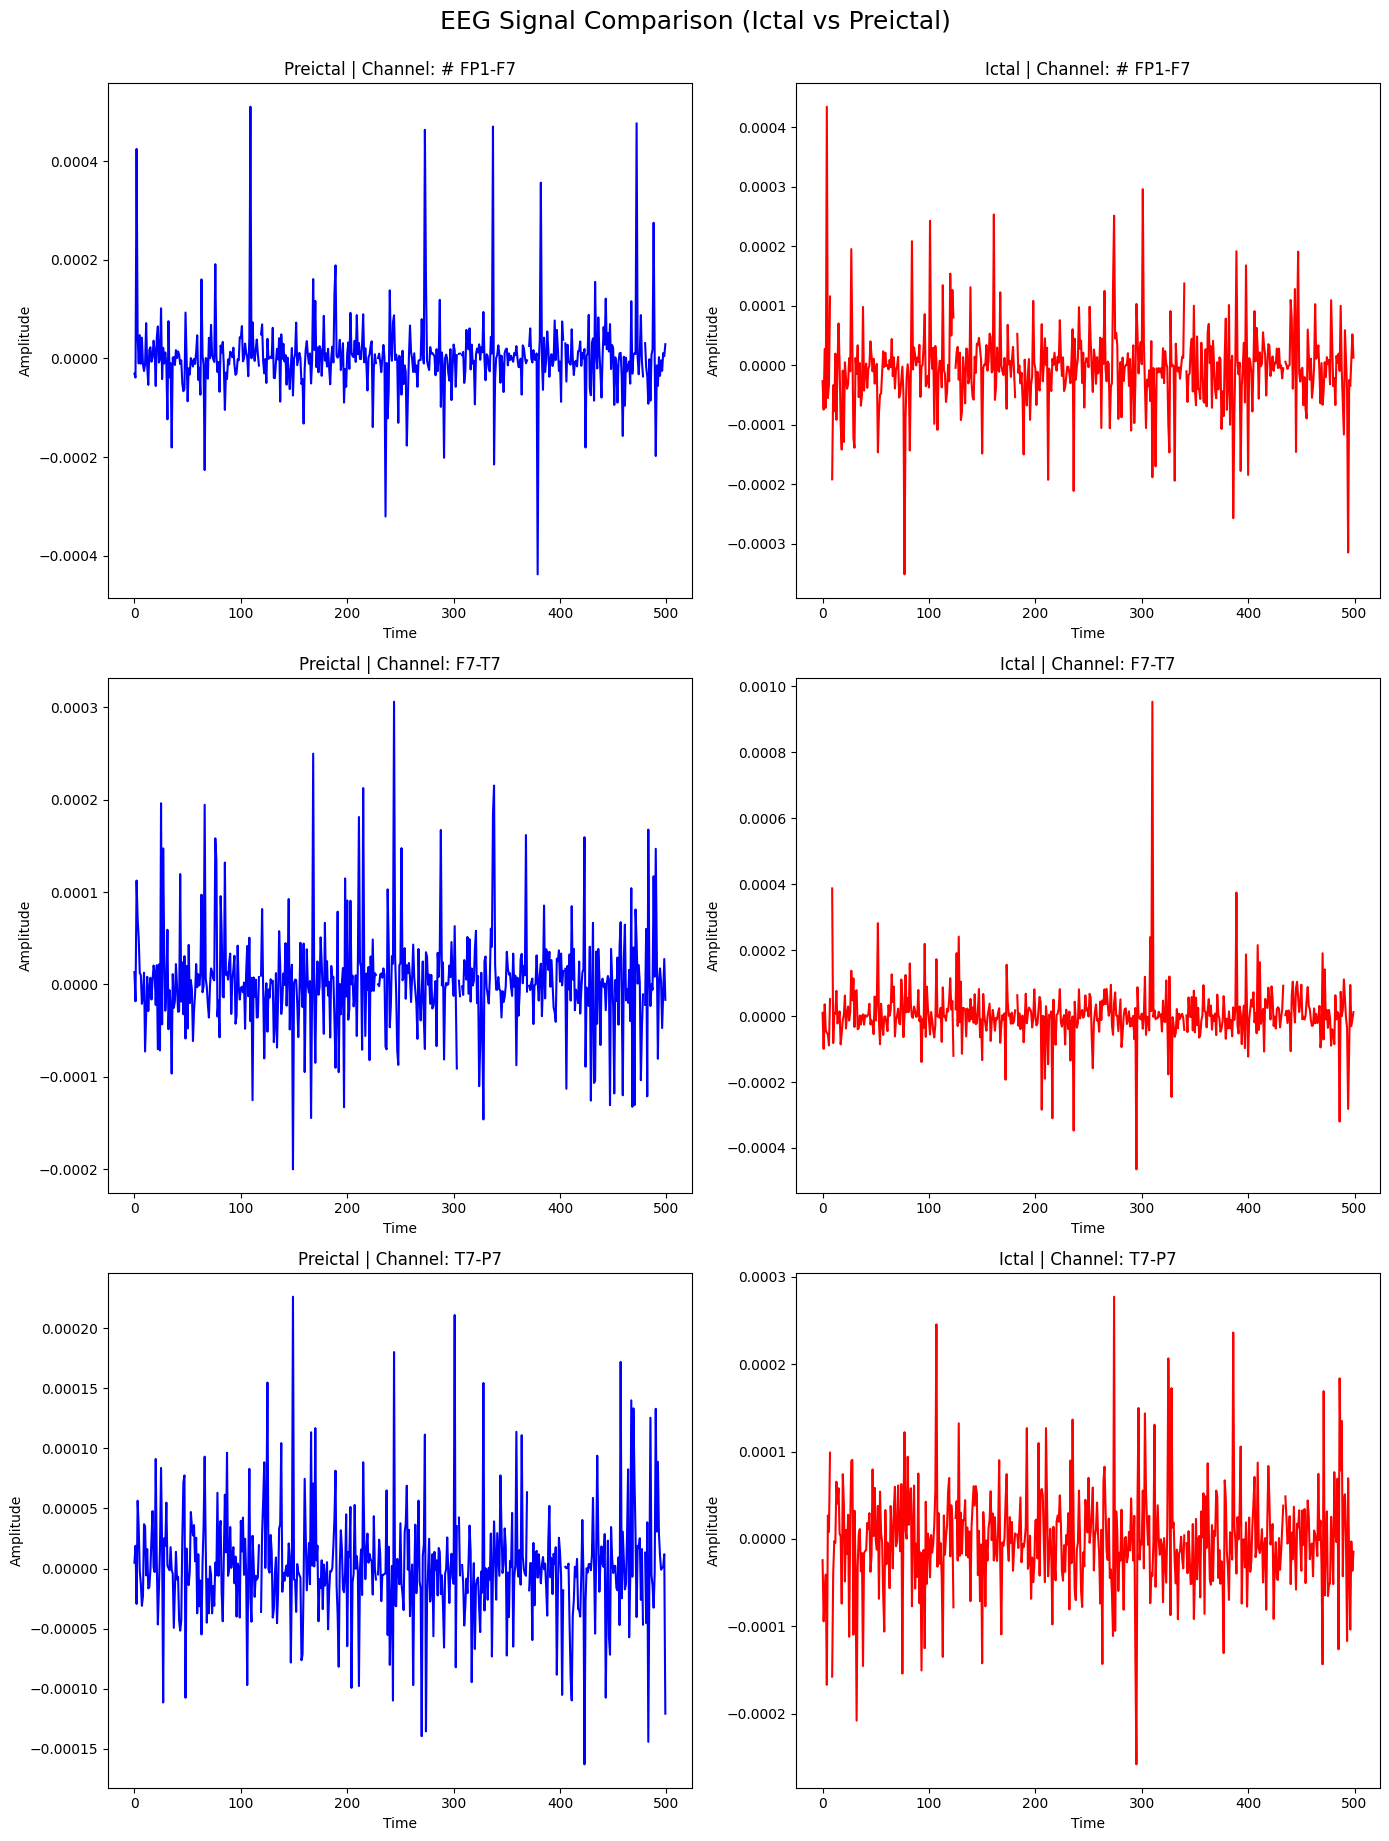

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the correct balanced dataset
df = pd.read_csv("/content/drive/MyDrive/balanced_chbmit_sampled.csv")

# Check if both classes exist
if 0 not in df['outcome'].values or 1 not in df['outcome'].values:
    print("One of the classes is missing in the dataset.")
else:
    # Select 3 channels for visualization
    channels_to_plot = df.columns[:3]

    # Sample from each class
    preictal_sample = df[df['outcome'] == 0].iloc[:500]
    ictal_sample = df[df['outcome'] == 1].iloc[:500]

    # Plot
    fig, axs = plt.subplots(len(channels_to_plot), 2, figsize=(14, 6 * len(channels_to_plot)))

    for i, ch in enumerate(channels_to_plot):
        axs[i, 0].plot(preictal_sample[ch].values, color='blue')
        axs[i, 0].set_title(f'Preictal | Channel: {ch}')
        axs[i, 0].set_xlabel('Time')
        axs[i, 0].set_ylabel('Amplitude')

        axs[i, 1].plot(ictal_sample[ch].values, color='red')
        axs[i, 1].set_title(f'Ictal | Channel: {ch}')
        axs[i, 1].set_xlabel('Time')
        axs[i, 1].set_ylabel('Amplitude')

    plt.tight_layout()
    plt.suptitle('EEG Signal Comparison (Ictal vs Preictal)', fontsize=18, y=1.02)
    plt.show()



## EEG Signal Comparison: Ictal vs Preictal

Visualization and comparison of EEG signals for the two classes: preictal and ictal, across several channels.

### Key Observations from the Plots

#### 1. **Amplitude Spikes**
- Ictal (Seizure) signals show a larger, sharper amplitude spikes.
- In contrast, preictal signals exhibit lower and smoother fluctuations.

*Interpretation*: Seizure events involve sudden bursts of neural activity, which manifest as abrupt, high-amplitude voltage changes in the EEG trace.

#### 2. **Signal Variability**
- Ictal signals exhibit higher variance, fluctuating more erratically.
- Preictal signals are more consistent and less volatile.

*Interpretation*: The brain’s electrical activity becomes more disorganized during seizures, showing less rhythmic and more chaotic behavior.

#### 3. **Baseline Fluctuations**
- Ictal traces show frequent deviations from the baseline.
- Preictal signals tend to remain near the baseline with smaller deviations.

 *Interpretation*: Increased baseline fluctuations during seizures suggest neural hyperactivity or dysfunction.

### Conclusion

> "The side-by-side comparison of EEG traces across key channels demonstrates that ictal periods are marked by distinctive, high-variance, and high-amplitude patterns. These visual and statistical differences are critical features leveraged in machine learning models for seizure prediction and classification."


Models for comparison:

1.Random Forest

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.92      0.90     27600
           1       0.92      0.88      0.90     27600

    accuracy                           0.90     55200
   macro avg       0.90      0.90      0.90     55200
weighted avg       0.90      0.90      0.90     55200



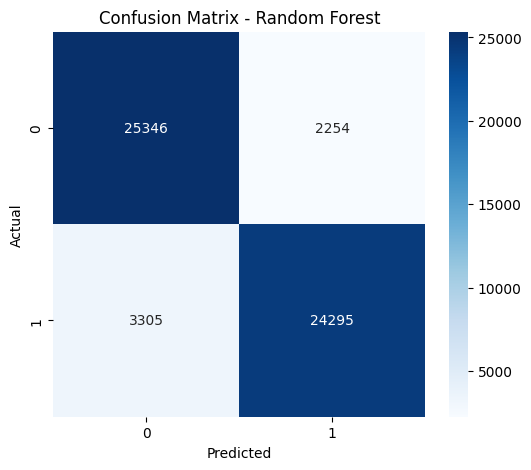

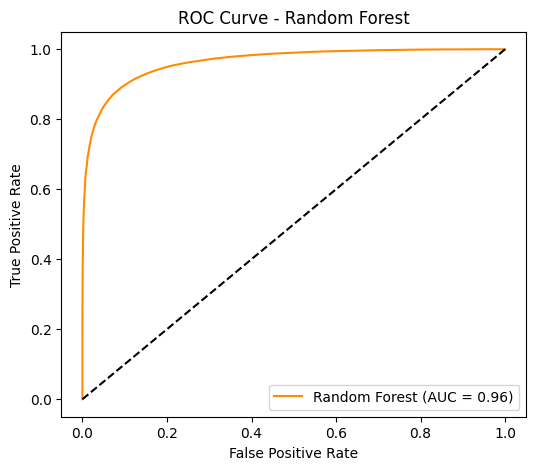

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Train the Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_scaled, y_train)

# Predictions
y_pred = rf.predict(X_test_scaled)
y_prob_rf = rf.predict_proba(X_test_scaled)[:, 1]  # for ROC

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Separate ROC Curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(6, 5))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend()
plt.show()


KNN

Classification Report - KNN (k=5):
               precision    recall  f1-score   support

           0       0.89      0.93      0.91     27600
           1       0.93      0.88      0.90     27600

    accuracy                           0.91     55200
   macro avg       0.91      0.91      0.91     55200
weighted avg       0.91      0.91      0.91     55200



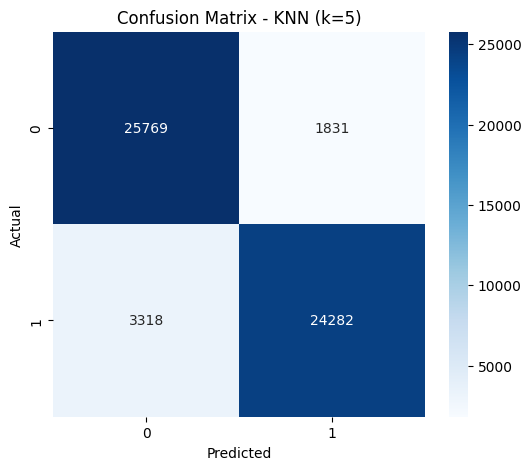

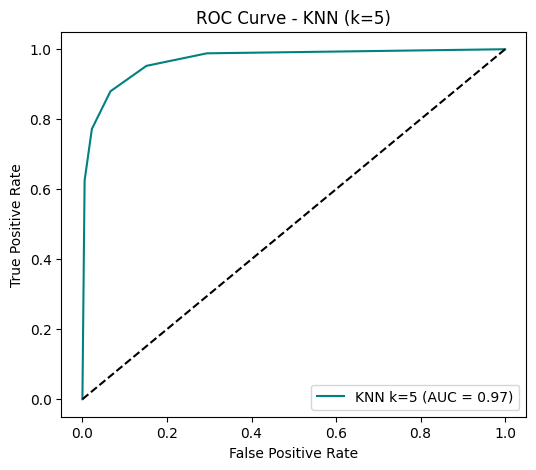

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

k_values = [3, 5, 7, 9, 11]
best_k = 5

knn = KNeighborsClassifier(n_neighbors=best_k, metric='euclidean')

# Fitting
knn.fit(X_train_scaled, y_train)

# Predictions
y_pred_knn = knn.predict(X_test_scaled)
y_prob_knn = knn.predict_proba(X_test_scaled)[:, 1]

# Classification Report
print(f"Classification Report - KNN (k={best_k}):\n", classification_report(y_test, y_pred_knn))

# Confusion Matrix
plt.figure(figsize=(6, 5))
cm_knn = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm_knn, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix - KNN (k={best_k})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_prob_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)

plt.figure(figsize=(6, 5))
plt.plot(fpr_knn, tpr_knn, label=f'KNN k={best_k} (AUC = {roc_auc_knn:.2f})', color='teal')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - KNN (k={best_k})')
plt.legend()
plt.show()

xGBoost

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:45:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report - XGBoost:
               precision    recall  f1-score   support

           0       0.72      0.79      0.76     27600
           1       0.77      0.70      0.73     27600

    accuracy                           0.74     55200
   macro avg       0.75      0.74      0.74     55200
weighted avg       0.75      0.74      0.74     55200



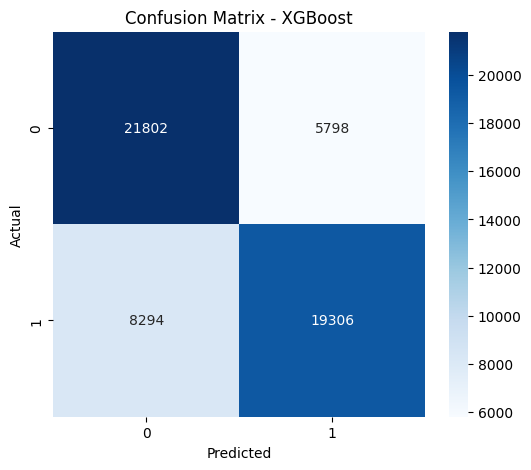

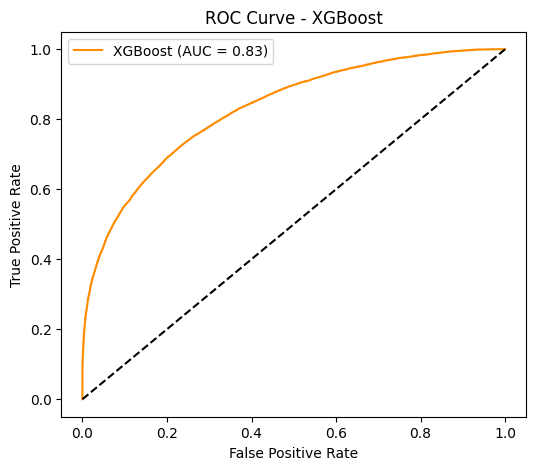

In [ ]:
# XGBoost Model
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize XGBoost classifier
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train
xgb_clf.fit(X_train_scaled, y_train)

# Predict
y_pred = xgb_clf.predict(X_test_scaled)
y_prob = xgb_clf.predict_proba(X_test_scaled)[:, 1]

# Classification report
print("Classification Report - XGBoost:\n", classification_report(y_test, y_pred))

# Confusion matrix
plt.figure(figsize=(6,5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob)
roc_auc_rgb = auc(fpr_xgb, tpr_xgb)

plt.figure(figsize=(6,5))
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_rgb:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend()
plt.show()


Logistic regression

 Classification Report - Logistic Regression:
               precision    recall  f1-score   support

           0       0.51      0.51      0.51     27600
           1       0.51      0.50      0.51     27600

    accuracy                           0.51     55200
   macro avg       0.51      0.51      0.51     55200
weighted avg       0.51      0.51      0.51     55200



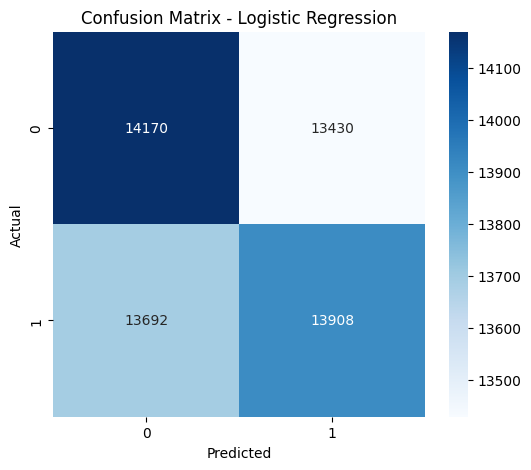

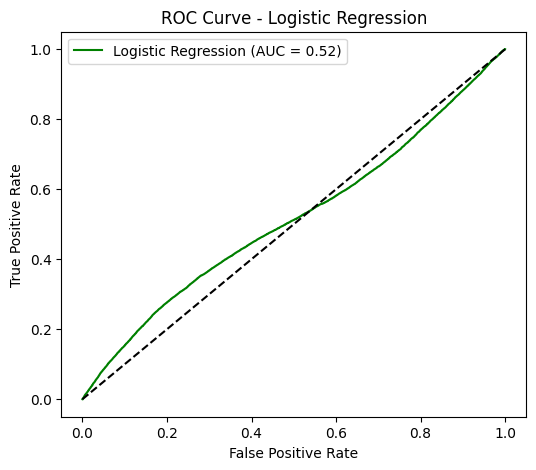

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize and train Logistic regression
lr = LogisticRegression(max_iter = 1000, random_state=42)
lr.fit(X_train_scaled, y_train)

# Predictions
y_pred_lr = lr.predict(X_test_scaled)
y_prob_lr = lr.predict_proba(X_test_scaled)[:, 1]

# Classification Report
print(" Classification Report - Logistic Regression:\n", classification_report(y_test, y_pred_lr))

# Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(figsize=(6, 5))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})', color='green')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend()
plt.show()

##  Logistic Regression Performance Explanation

### Observations:
- The **accuracy (51%)** and **AUC (0.52)** of Logistic Regression are close to random guessing.
- The **confusion matrix** shows nearly equal misclassifications across both classes.
- The **ROC curve** closely follows the diagonal reference line, indicating poor class separability.

### Why Logistic Regression Performed Poorly:
1. **Linear Model Limitation:**
   - Logistic Regression assumes a linear relationship between input features and the target classes.
   - EEG signals are highly non-linear and complex, which a linear decision boundary cannot effectively capture.

2. **High Dimensionality:**
   - The EEG dataset has many features (channels), each with intricate patterns.
   - Linear models struggle to separate classes in such high-dimensional feature spaces.

3. **Temporal Complexity:**
   - EEG signals are time-series data with sequential dependencies.
   - Logistic Regression ignores the temporal structure and treats each sample as independent, which leads to poor learning.

4. **Feature Interactions:**
   - EEG data contains interactions across multiple electrodes and time windows that logistic regression cannot model effectively.
   - More complex models are required to capture these non-linear relationships.

> The poor performance of Logistic Regression in this EEG seizure prediction task is expected. EEG classification typically requires non-linear, flexible models (e.g., Random Forest, XGBoost, SVM with non-linear kernels) that can handle:
- High-dimensional feature spaces
- Complex temporal patterns
- Non-linear decision boundaries

Models that leverage EEG signals use advanced non-linear models to generalize properly


Comparison of all models used

,accuracy,precision,recall,f1,auc
Random Forest,0.90,0.90,0.90,0.90,0.96
KNN,0.91,0.91,0.91,0.91,0.97
XGBoost,0.74,0.75,0.74,0.74,0.83
Logistic Regression,0.51,0.51,0.51,0.51,0.52


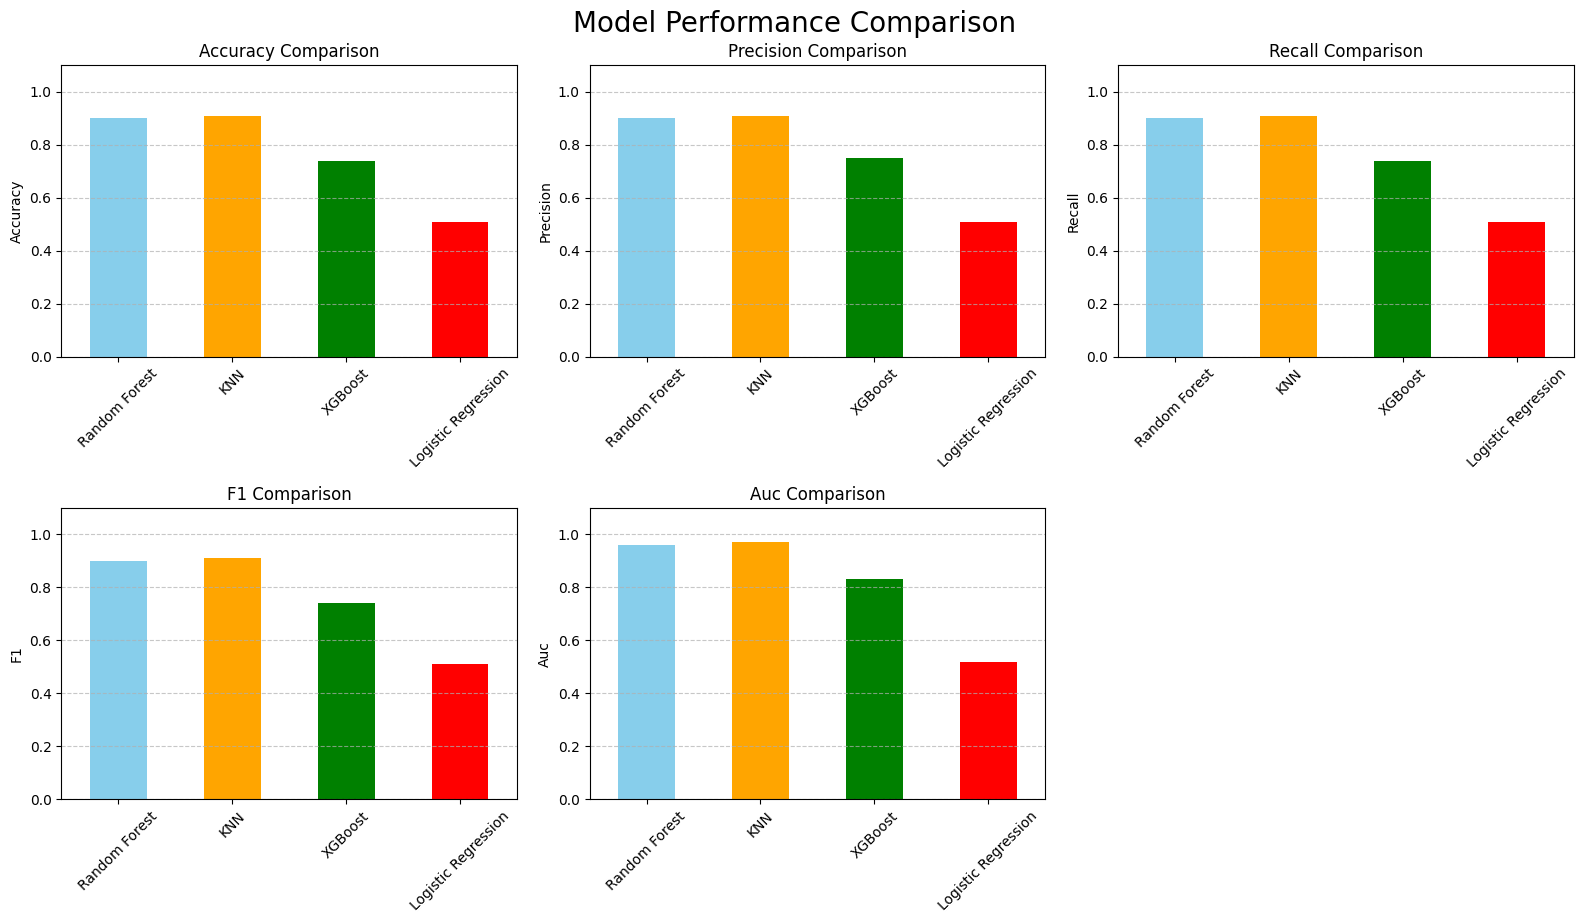

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Model results based on model outputs
model_results = {
    'Random Forest': {'accuracy': 0.90, 'precision': 0.90, 'recall': 0.90, 'f1': 0.90, 'auc': 0.96},
    'KNN': {'accuracy': 0.91, 'precision': 0.91, 'recall': 0.91, 'f1': 0.91, 'auc': 0.97},
    'XGBoost': {'accuracy': 0.74, 'precision': 0.75, 'recall': 0.74, 'f1': 0.74, 'auc': 0.83},
    'Logistic Regression': {'accuracy': 0.51, 'precision': 0.51, 'recall': 0.51, 'f1': 0.51, 'auc': 0.52}
}

# Conversion to DataFrame
summary_df = pd.DataFrame(model_results).T
display(summary_df)

# Plot comparison
metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']

plt.figure(figsize=(16, 9))

for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 3, i)
    summary_df[metric].plot(kind='bar', color=['skyblue', 'orange', 'green', 'red'])
    plt.title(f'{metric.capitalize()} Comparison')
    plt.ylabel(metric.capitalize())
    plt.ylim(0, 1.1)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.suptitle('Model Performance Comparison', fontsize=20, y=1.02)
plt.show()


Final AUC-ROC curve

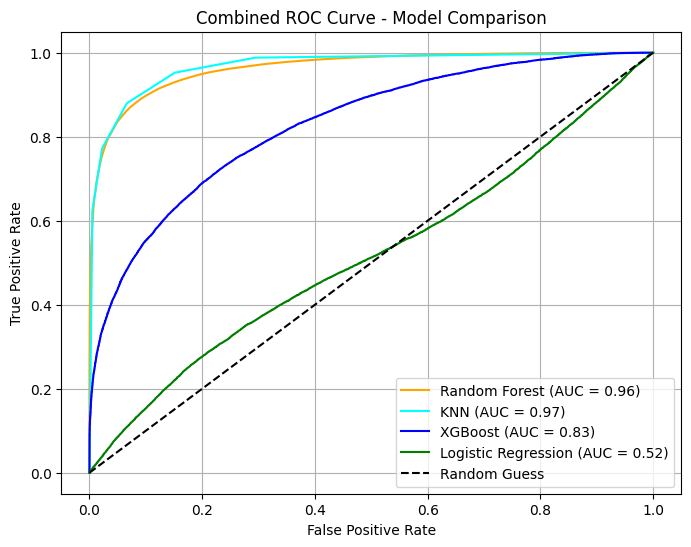

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Random Forest ROC
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# KNN ROC
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_prob_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)

# XGBoost ROC
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Logistic Regression ROC
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

# Plot all ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='orange', label='Random Forest (AUC = {:.2f})'.format(roc_auc_rf))
plt.plot(fpr_knn, tpr_knn, color='cyan', label='KNN (AUC = {:.2f})'.format(roc_auc_knn))
plt.plot(fpr_xgb, tpr_xgb, color='blue', label='XGBoost (AUC = {:.2f})'.format(roc_auc_xgb))  # Should display 0.83
plt.plot(fpr_lr, tpr_lr, color='green', label='Logistic Regression (AUC = {:.2f})'.format(roc_auc_lr))


plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Combined ROC Curve - Model Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


##  Model Performance Comparison: Conclusions

The bar charts above compare the performance of four models across key evaluation metrics: Accuracy, Precision, Recall, F1 Score, and AUC.

### Key Observations:
- Random Forest and KNN consistently outperformed the other models across all metrics.
- KNN slightly edges out Random Forest in precision, recall, F1 score, and AUC, suggesting it was the best-performing model in this project.
- XGBoost delivered moderate performance, performing better than Logistic Regression but worse than Random Forest and KNN.
- Logistic Regression performed the poorest, with all metrics significantly lower than the other models. This is because it is a linear model and hence struggles to capture the complex patterns present in EEG data.

### Insights:
- Non-linear models (Random Forest, KNN, XGBoost) are better suited for EEG-based seizure prediction tasks due to their ability to capture intricate relationships and variability in EEG signals.
- Model complexity and flexibility play a crucial role in performance, as seen from the poor results of Logistic Regression, which assumes linear separability.
- The AUC comparisons reinforce the reliability of Random Forest and KNN, both having excellent discriminatory power between seizure and non-seizure events.

### Conclusion:
- KNN and Random Forest are the top candidates for this seizure prediction problem.
- XGBoost remains a solid option but may benefit from further tuning or feature engineering.
- Logistic Regression and other linear models such as perceptrons are not suitable for this type of time-series task that involves complex EEG signal classification. This is due to due to their limited capability to capture non-linear dependencies.

### Future Works
Future work can be explored:
- Using deep learning
- Exploration of ensemble methods
- Implementing a wearable EEG monitoring device
